In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/data-science-bowl-2019/test.csv
/kaggle/input/data-science-bowl-2019/specs.csv
/kaggle/input/data-science-bowl-2019/train.csv
/kaggle/input/data-science-bowl-2019/train_labels.csv
/kaggle/input/data-science-bowl-2019/sample_submission.csv


In [2]:
import IPython

def display(*dfs):
    for df in dfs:
        IPython.display.display(df)


In [3]:
## Function to reduce the DF size
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [4]:
%time df = pd.read_csv('/kaggle/input/data-science-bowl-2019/train.csv', engine='c')
labels = pd.read_csv('/kaggle/input/data-science-bowl-2019/train_labels.csv')

CPU times: user 1min 15s, sys: 11.5 s, total: 1min 27s
Wall time: 1min 27s


In [5]:
df_test = pd.read_csv('/kaggle/input/data-science-bowl-2019/test.csv')

In [6]:
df = reduce_mem_usage(df)
labels = reduce_mem_usage(labels)
df_test = reduce_mem_usage(df_test)

Mem. usage decreased to 778.73 Mb (18.2% reduction)
Mem. usage decreased to  0.49 Mb (48.2% reduction)
Mem. usage decreased to 79.40 Mb (18.2% reduction)


# Number of unique users

In [7]:
train_id = df.installation_id.unique()
test_id = df_test.installation_id.unique()

print('# of unique ids in train:', train_id.shape[0])
print('# of unique ids in test:', test_id.shape[0])
print('# of unique ids from test set in train set:', np.isin(test_id, train_id).sum())

# of unique ids in train: 17000
# of unique ids in test: 1000
# of unique ids from test set in train set: 0


# Timestamp

In [8]:
df['timestamp'] = pd.to_datetime(df['timestamp'])
df_test['timestamp'] = pd.to_datetime(df_test['timestamp'])

In [9]:
df.timestamp.describe(), df_test.timestamp.describe()

(count                             11341042
 unique                            10777308
 top       2019-08-01 20:08:13.052000+00:00
 freq                                    11
 first     2019-07-23 02:12:17.279000+00:00
 last      2019-10-22 17:41:45.983000+00:00
 Name: timestamp, dtype: object, count                              1156414
 unique                             1103166
 top       2019-09-13 18:38:38.848000+00:00
 freq                                     9
 first     2019-07-24 00:04:25.361000+00:00
 last      2019-10-14 21:00:34.858000+00:00
 Name: timestamp, dtype: object)

The same time period for train and test

# Number of user with attempts
How many installation_id in test set have assessment and assessment with finished code?

In [10]:
def event_finished(df):
    df_wt_BM = df[(df.event_code == 4100) & (df.title.str.find('Bird Measurer')==-1)]
    df_BM = df[(df.event_code == 4110) & (df.title.str.find('Bird Measurer')!=-1)]
    return df_wt_BM.append(df_BM)

In [11]:
# for test
assessment = df_test[df_test.type=='Assessment']
assessment_finished = event_finished(assessment)

In [12]:
print('# ids in TEST\t # ids in assessment\t # ids in finished assessments')
print(test_id.shape,'\t', assessment.installation_id.unique().shape, '\t\t',
      assessment_finished.installation_id.unique().shape)

# ids in TEST	 # ids in assessment	 # ids in finished assessments
(1000,) 	 (1000,) 		 (557,)


In [13]:
# for train
assessment = df[df.type=='Assessment']
assessment_finished = event_finished(assessment)

In [14]:
print('# ids in TRAIN\t # ids in assessment\t # ids in finished assessments')
print(train_id.shape,'\t', assessment.installation_id.unique().shape, '\t\t',
      assessment_finished.installation_id.unique().shape)

# ids in TRAIN	 # ids in assessment	 # ids in finished assessments
(17000,) 	 (4242,) 		 (3614,)


For test set - each id took assessments, whereas a lot of ids in train set never took assesments (only 25% did it) and  only around 21% of ids finished assessments (correct or not). We can train model on these 21% ids.

In [15]:
df_ini = df.copy()

# Correct attempt counter
Let's look on test set to see, how many correct attempts already have user up to moment last attempt. 
Why? Logically, one can  assume, that previous attempts (as correct well as not) ma improve user's knoledge and increase chance to pass attemp. But we should undestand that such kind of indormation should be in test set. Let's check it.

In [16]:
# indicate assessment finish; don't care correct ot not
def check_attempt(df):
    df['attempt'] = ((df.type == 'Assessment') &
                       (((df.event_code == 4100) & (df.title != 'Bird Measurer (Assessment)')) |
                        ((df.event_code == 4110)&(df.title == 'Bird Measurer (Assessment)')) )
                   ).astype('int8')

# indicate that attempt was correct
def check_correct(df):
    df['correct'] = 0
    df.loc[df.attempt == 1, 'correct'] = df[df.attempt == 1].event_data.str.contains('"correct":true').astype('int8')

In [17]:
df = df_ini.copy()

# we will look only on users which have info about attempts
df = df[df.installation_id.isin(labels.installation_id)]


In [18]:
check_attempt(df_test)
check_correct(df_test)

check_attempt(df)
check_correct(df)

In [19]:
test_group = df_test.groupby('installation_id')
train_group = df.groupby('installation_id')

In [20]:
import matplotlib.pyplot as plt

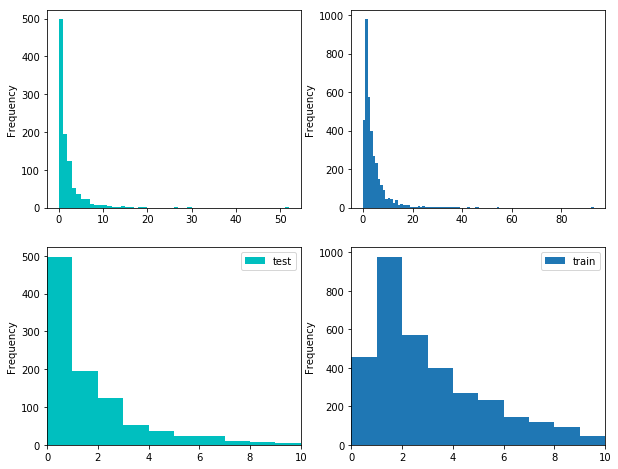

In [21]:
plt.figure(figsize=(10,8))
plt.subplot(2,2,1)
ax = test_group.correct.sum().plot.hist(bins=test_group.correct.sum().max(), color='c');

plt.subplot(2,2,2)
ax = train_group.correct.sum().plot.hist(bins=train_group.correct.sum().max())


plt.subplot(2,2,3)
ax = test_group.correct.sum().plot.hist(bins=test_group.correct.sum().max(), label='test', color='c');
ax.set_xlim(0,10)
plt.legend();

plt.subplot(2,2,4)
ax = train_group.correct.sum().plot.hist(bins=train_group.correct.sum().max(), label='train')
ax.set_xlim(0,10);
plt.legend();

Test set have comlicated installation_id's history with already passed assessments.

**Note: ** in train set info for each intsllation_id should include also info about previous assessments

# Check unique titles in different worlds

In [22]:
temp = df_test[df_test.type=='Assessment'].groupby('world').title.unique()

for i in temp.index:
    print(i, temp[i])

CRYSTALCAVES ['Cart Balancer (Assessment)' 'Chest Sorter (Assessment)']
MAGMAPEAK ['Cauldron Filler (Assessment)']
TREETOPCITY ['Mushroom Sorter (Assessment)' 'Bird Measurer (Assessment)']


# Check final assessment repeating
User can alredy start with assessment but not finish it or finish it with wrong answer, etc

In [23]:
# for each installation_id, count repeats by each game_session
def count_last_assessment_repeat(df_test):
    temp = df_test[df_test.type == 'Assessment']
    last_attempts = temp.groupby('installation_id').title.apply(lambda x: x.iloc[-1])
    # last_attempts

    results = []
    for i, session in temp.groupby(['installation_id'], sort=False):
        res = {}
        last_title = session.title.iloc[-1]
        t = session.iloc[:-1][session.title == last_title].groupby('game_session').agg({'title': lambda x: x.iloc[0],
                                                                                       'attempt': lambda x: 1 if x.sum() >=1 else 0,
                                                                                       'correct': 'sum'})
        if  (t.correct >1).any():
            display(t)
            input()
        res['installation_id'] = i
        res['last_title'] = last_title
        res['n_users_with_repeat'] = 1 if t.shape[0]> 0 else 0
        res['n_repeat'] = t.shape[0] # all repeats
        res['n_attempt'] = t.attempt.sum() # sum game_sessions with attemption
        res['n_correct'] = t.correct.sum() 

        results.append(res)

    return pd.DataFrame(results)   

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()


n_users_with_repeat    271.0
n_repeat               489.0
n_attempt              426.0
n_correct              339.0
dtype: float64

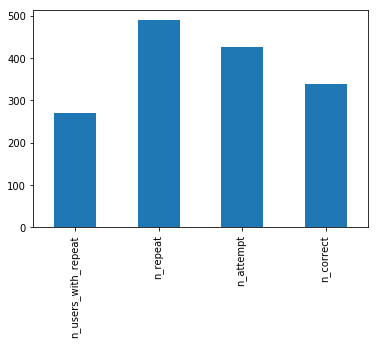

In [24]:
results = count_last_assessment_repeat(df_test)
results.drop(['installation_id', 'last_title'], axis=1).sum().plot.bar();
results.drop(['installation_id', 'last_title'], axis=1).sum()

Total: 
* 271 installation_id (from 1000)  have already started/finished/carrected pass the last assemption.
* difference between n_repeat and n_attempt tell us that there were some starting assemptions but they was not finished

Check train set too

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()


n_users_with_repeat    3613.0
n_repeat               7079.0
n_attempt              6239.0
n_correct              4615.0
dtype: float64

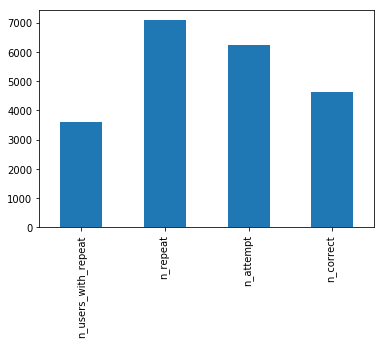

In [25]:
results = count_last_assessment_repeat(df)
results.drop(['installation_id', 'last_title'], axis=1).sum().plot.bar();
results.drop(['installation_id', 'last_title'], axis=1).sum()

Look at one user closer

In [26]:
user_id = '01242218'

user = df_test[df_test.installation_id == user_id].copy()

last_attempt = user[user.type == 'Assessment'].iloc[-1]
last_attempt

event_id                                                    7ad3efc6
game_session                                        1fef5d54cb4b775a
timestamp                           2019-10-09 20:23:16.209000+00:00
event_data         {"version":"1.0","event_count":1,"game_time":0...
installation_id                                             01242218
event_count                                                        1
event_code                                                      2000
game_time                                                          0
title                                     Cart Balancer (Assessment)
type                                                      Assessment
world                                                   CRYSTALCAVES
attempt                                                            0
correct                                                            0
Name: 3586, dtype: object

In [27]:
user[user.title == last_attempt.title]

,event_id,game_session,timestamp,event_data,installation_id,event_count,event_code,game_time,title,type,world,attempt,correct
1953,7ad3efc6,e8e62de939f916bc,2019-09-22 21:38:58.329000+00:00,"{""version"":""1.0"",""event_count"":1,""game_time"":0...",01242218,1,2000,0,Cart Balancer (Assessment),Assessment,CRYSTALCAVES,0,0
1954,65a38bf7,e8e62de939f916bc,2019-09-22 21:38:58.430000+00:00,"{""crystals"":[{""id"":""gem07"",""weight"":6},{""id"":""...",01242218,2,2020,64,Cart Balancer (Assessment),Assessment,CRYSTALCAVES,0,0
1955,795e4a37,e8e62de939f916bc,2019-09-22 21:38:58.437000+00:00,"{""description"":""We've got to balance this scal...",01242218,3,3010,64,Cart Balancer (Assessment),Assessment,CRYSTALCAVES,0,0
1956,5e109ec3,e8e62de939f916bc,2019-09-22 21:39:02.124000+00:00,"{""crystal_id"":""gem08"",""weight"":6,""coordinates""...",01242218,4,4030,3788,Cart Balancer (Assessment),Assessment,CRYSTALCAVES,0,0
1957,5c2f29ca,e8e62de939f916bc,2019-09-22 21:39:03.164000+00:00,"{""crystal_id"":""gem08"",""weight"":6,""coordinates""...",01242218,5,4020,4854,Cart Balancer (Assessment),Assessment,CRYSTALCAVES,0,0
1958,5e109ec3,e8e62de939f916bc,2019-09-22 21:39:04.084000+00:00,"{""crystal_id"":""gem07"",""weight"":6,""coordinates""...",01242218,6,4030,5754,Cart Balancer (Assessment),Assessment,CRYSTALCAVES,0,0
1959,5c2f29ca,e8e62de939f916bc,2019-09-22 21:39:04.727000+00:00,"{""crystal_id"":""gem07"",""weight"":6,""coordinates""...",01242218,7,4020,6421,Cart Balancer (Assessment),Assessment,CRYSTALCAVES,0,0
1960,828e68f9,e8e62de939f916bc,2019-09-22 21:39:05.454000+00:00,"{""description"":""We've got to balance this scal...",01242218,8,3110,7154,Cart Balancer (Assessment),Assessment,CRYSTALCAVES,0,0
1961,d122731b,e8e62de939f916bc,2019-09-22 21:39:06.838000+00:00,"{""correct"":true,""left"":[{""id"":""gem07"",""weight""...",01242218,9,4100,8504,Cart Balancer (Assessment),Assessment,CRYSTALCAVES,1,1
1962,a8876db3,e8e62de939f916bc,2019-09-22 21:39:06.848000+00:00,"{""description"":""You did it! The weight is equa...",01242218,10,3021,8504,Cart Balancer (Assessment),Assessment,CRYSTALCAVES,0,0


Let's look on data: we can see that 
* user start assessment (title and event_id are the same as the last one), 
* finished it (event_code=4100), 
* still play in this assessment (the same game_session)

* and last one, we see out aseessment to predict


So, information that user already passed/tried to pass/started last assessment can influence on result

**Note:** store info about last_assessment type